In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pytesseract
from pytesseract import Output

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout


In [2]:
le = LabelEncoder()
images = []
labels = []

training_paths = ['data/raw/character_set1/training_data/',
                 'data/raw/character_set3/training_data/', ]
#testing_path = 'data/raw/character_set1/testing_data/'


In [3]:
for training_path in training_paths:
    dir_list = os.listdir(training_path)
    for i in dir_list:
        print(f"Processing label: {i}")  # Add this line to check labels
        dir = os.path.join(training_path, i)
        file_list = os.listdir(dir)
        for j in file_list:
            files = os.path.join(dir, j)
            img = cv2.imread(files, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to read image {files}. Skipping.")
                continue
            img = cv2.resize(img, (64, 64))
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(i)

Processing label: 0
Processing label: 1
Processing label: 2
Processing label: 3
Processing label: 4
Processing label: 5
Processing label: 6
Processing label: 7
Processing label: 8
Processing label: 9
Processing label: A
Processing label: B
Processing label: C
Processing label: D
Processing label: E
Processing label: F
Processing label: G
Processing label: H
Processing label: I
Processing label: J
Processing label: K
Processing label: L
Processing label: M
Processing label: N
Processing label: O
Processing label: P
Processing label: Q
Processing label: R
Processing label: S
Processing label: T
Processing label: U
Processing label: V
Processing label: W
Processing label: X
Processing label: Y
Processing label: Z
Processing label: a
Processing label: b
Processing label: c
Processing label: d
Processing label: e
Processing label: f
Processing label: g
Processing label: h
Processing label: i
Processing label: j
Processing label: k
Processing label: l
Processing label: m
Processing label: n


## Print out details of X and y

In [4]:
X = np.array(images)
print("len(X): ",len(X))
print("X.shape: ", X.shape)

y = np.array(labels)
print("len(y): ",len(y))
print("y.shape: ", y.shape)

len(X):  105770
X.shape:  (105770, 64, 64, 1)
len(y):  105770
y.shape:  (105770,)


In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
print("Classes:", le.classes_)
X_sh, y_sh = shuffle(X, y, random_state=42)

Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [6]:
# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_sh, y_sh, test_size=0.2, random_state=42, stratify=y_sh
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 84616
Testing samples: 21154


# Create Keras model
create a neural network model

In [7]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=len(le.classes_), activation='softmax')
])

C:\Users\Dell G3\English-Braille-translator\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

C:\Users\Dell G3\English-Braille-translator\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3385/3385 ━━━━━━━━━━━━━━━━━━━━ 162s 47ms/step - accuracy: 0.3670 - loss: 2.3314 - val_accuracy: 0.9033 - val_loss: 0.3894


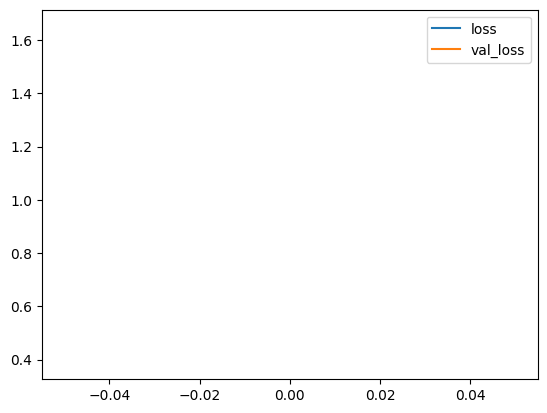

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the data generator
datagen.fit(X_train)

# Use the generator in model training
history = model.fit(datagen.flow(X_train, y_train, batch_size=25),
                    validation_data=(X_test, y_test), epochs=1)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [10]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Separate Evaluation for Uppercase and Lowercase Characters

# Determine the number of uppercase letters
# This assumes that the first 'num_uppercase' classes are uppercase letters
# Adjust 'num_uppercase' based on your actual label encoding
num_uppercase = 26  # Typically, A-Z

# Find indices for uppercase and lowercase characters
uppercase_indices = np.where(y_test < num_uppercase)
lowercase_indices = np.where(y_test >= num_uppercase)

# Evaluate the model on uppercase characters
test_loss_upper, test_acc_upper = model.evaluate(X_test[uppercase_indices], y_test[uppercase_indices], verbose=0)
print(f"Uppercase Test Loss: {test_loss_upper:.4f}")
print(f"Uppercase Test Accuracy: {test_acc_upper:.4f}")

# Evaluate the model on lowercase characters
test_loss_lower, test_acc_lower = model.evaluate(X_test[lowercase_indices], y_test[lowercase_indices], verbose=0)
print(f"Lowercase Test Loss: {test_loss_lower:.4f}")
print(f"Lowercase Test Accuracy: {test_acc_lower:.4f}")



662/662 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9002 - loss: 0.3993
Test Loss: 0.3894
Test Accuracy: 0.9033
662/662 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9002 - loss: 0.3993
Test Loss: 0.3894
Test Accuracy: 0.9033
Uppercase Test Loss: 0.4390
Uppercase Test Accuracy: 0.8940
Lowercase Test Loss: 0.3812
Lowercase Test Accuracy: 0.9048


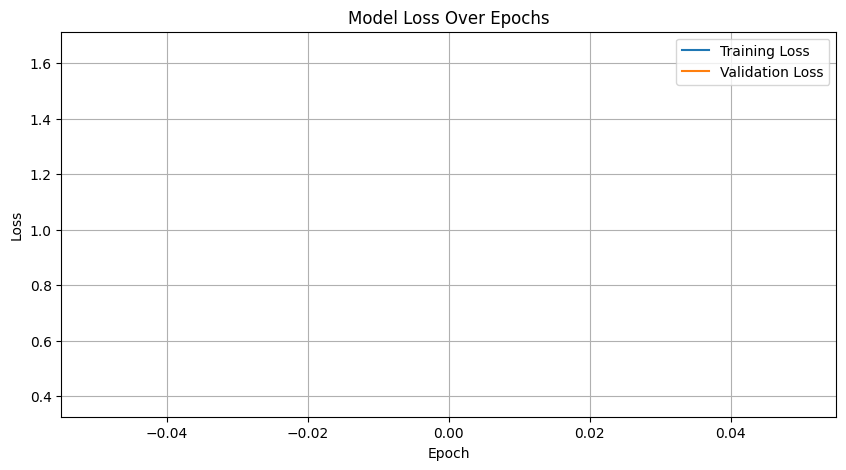

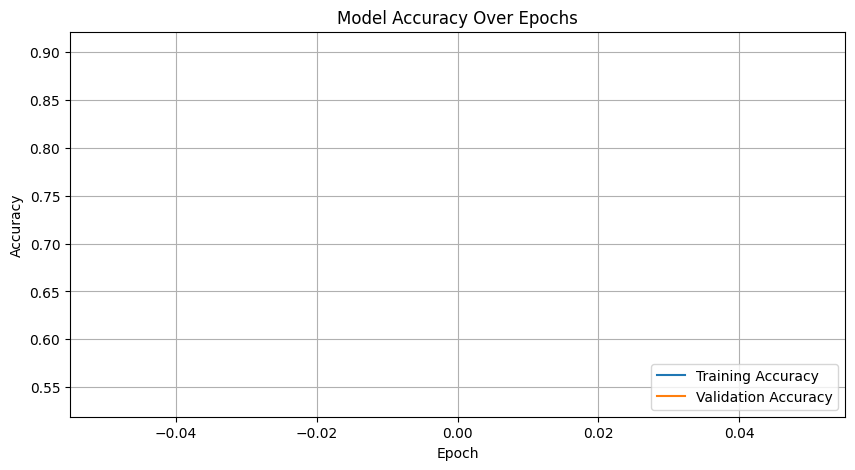

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Visualization

### Visualize Regions

In [12]:
def visualize_regions(image, regions):
    debug_image = image.copy()
    for (x, y, w, h) in regions:
        cv2.rectangle(debug_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imshow("Detected Text Regions", debug_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### Visualize Processed Image

In [13]:
def display_processed_image(window_name, processed_image):
    cv2.imshow(window_name, processed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Image Processing Operations

In [14]:
def image_processing_operations_visualization(image, operation):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if operation == 'threshold':
        # Apply thresholding to get a binary image
        _, processed_image = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        window_name = "Thresholded Image"

    elif operation == 'erosion':
        # Apply thresholding and then erosion
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((2, 1), np.uint8)
        processed_image = cv2.erode(thresh, kernel, iterations=1)
        window_name = "Eroded Image"

    elif operation == 'dilation':
        # Apply thresholding and then dilation
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((1, 1), np.uint8)
        processed_image = cv2.dilate(thresh, kernel, iterations=1)
        window_name = "Dilated Image"

    else:
        raise ValueError("Operation must be 'threshold', 'erosion', or 'dilation'")

    # Display the processed image
    display_processed_image(window_name, processed_image)
    
    return _, processed_image

## Italic Characters Detection

### Compute Skew Angle

In [15]:
def compute_skew_angle(region):
    # Use moments to calculate the skew angle of a text region
    coords = np.column_stack(np.where(region > 0))
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    return angle

### Deskew Angle

In [16]:
def deskew_region(region, angle):
    # Rotate the region by the computed angle
    (h, w) = region.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(region, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotated

## Detect Text Regions

In [17]:
def detect_text_regions(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply adaptive thresholding with adjusted parameters
    processed_image = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 10  # Increased block size and constant
    )
    
    # Find contours
    contours, _ = cv2.findContours(
        processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Adjusted size thresholds
        if w > 3 and h > 3:
            regions.append((x, y, w, h))
    return regions

## Sorting Bounding Boxes by Rows and Columns

In [18]:
def sort_bounding_boxes(regions):
    # Sort by `y` first (top-to-bottom) with a threshold to group by rows
    row_threshold = 20  # Adjust based on character spacing
    regions = sorted(regions, key=lambda box: box[1])

    # Group bounding boxes into rows
    rows = []
    current_row = [regions[0]]
    
    for i in range(1, len(regions)):
        if abs(regions[i][1] - current_row[-1][1]) < row_threshold:
            current_row.append(regions[i])
        else:
            rows.append(current_row)
            current_row = [regions[i]]
    rows.append(current_row)
    
    # Sort each row left-to-right
    sorted_regions = []
    for row in rows:
        sorted_row = sorted(row, key=lambda box: box[0])
        sorted_regions.extend(sorted_row)
    
    return sorted_regions


## Resize Image Operation

In [19]:
def resize_image(image, target_size=(64, 64)):
    # Resize while maintaining aspect ratio and pad the image
    (h, w) = image.shape[:2]
    scaling_factor = min(target_size[0]/w, target_size[1]/h)
    new_size = (int(w * scaling_factor), int(h * scaling_factor))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    
    # Pad the resized image to make it target_size
    delta_w = target_size[0] - new_size[0]
    delta_h = target_size[1] - new_size[1]
    top, bottom = delta_h//2, delta_h - (delta_h//2)
    left, right = delta_w//2, delta_w - (delta_w//2)
    padded_image = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right,
        cv2.BORDER_CONSTANT, value=255
    )
    return padded_image

## Recognize Characters with Pytesseract
Using Pytesseract to detect text regions

In [28]:
def recognize_characters_with_pytesseract(image):
    """
    Use pytesseract to detect text regions and acquire the bounding boxes
    
    Parameters:
        image (numpy.ndarray): The input image
    Returns:
        list: A list of bounding boxes for the detected text regions
    """
    regions = []
    # Convert image to grayscale (optional, but can improve results)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding (optional)
    processed_image = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 10
    )
    
    # Use pytesseract to get bounding box
    # Output type `Output.DICT` gives detailed information
    boxes = pytesseract.image_to_boxes(processed_image, output_type=Output.DICT)
    
    for i in range(len(boxes['char'])):
        # Get bounding box coordinates
        x, y, w, h = boxes['left'][i], boxes['top'][i], boxes['right'][i], boxes['bottom'][i]

        # Tesseract's coordinate system starts from the bottom-left
        # Flip y-coordinates for OpenCV
        y = image.shape[0] - y
        h = image.shape[0] - h

        # Crop the text region from the image
        cropped = image[h:y, x:w]
        regions.append(cropped)

        # Optionally, draw rectangles on the original image for visualization
        cv2.rectangle(image, (x, h), (w, y), (0, 255, 0), 2)
        
    # Show the annotated image (for debugging/visualization)
    cv2.imshow("Detected Text Regions", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return regions

## Recognize Characters

In [21]:
def recognize_characters(image, model, label_encoder):
    #regions = detect_text_regions(image)
    regions = recognize_characters_with_pytesseract(image)
    sorted_regions = sort_bounding_boxes(regions)
    characters = []
    for (x, y, w, h) in sorted_regions:
        char_image = image[y:y+h, x:x+w]
        # Convert to grayscale if necessary
        if len(char_image.shape) == 3:
            char_image = cv2.cvtColor(char_image, cv2.COLOR_BGR2GRAY)
        # Deskew the character image
        angle = compute_skew_angle(char_image)
        char_image = deskew_region(char_image, angle)
        # Resize and normalize
        char_image_resized = resize_image(char_image, (64, 64))
        char_image_normalized = char_image_resized.astype('float32') / 255.0
        # Expand dimensions to match input shape
        char_image_normalized = np.expand_dims(char_image_normalized, axis=-1)
        char_image_normalized = np.expand_dims(char_image_normalized, axis=0)
        # Predict
        prediction = model.predict(char_image_normalized)
        predicted_class = np.argmax(prediction, axis=1)
        predicted_char = label_encoder.inverse_transform(predicted_class)[0]
        characters.append(predicted_char)
    return characters

# Driver Code

In [29]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

imggg = 'data/raw/character_set1/Test_4.png'
ground_truth = '0123456789thequickbrownfoxjumpsoverthelazydogTHEQUICKBROWNFOXJUMPSOVERTHELAZYDOGheLloWorlD'
image = cv2.imread(imggg) 
y_pred = recognize_characters(image, model, le)
print(y_pred)
print(len(y_pred))
print(''.join(y_pred))
#print('IntroductiontoAlgorithmsFourthEdition')
print(ground_truth)
print(len(ground_truth))

# Load a single lowercase character image
test_img = cv2.imread('data/raw/character_set3/training_data/c/C_L_5.png', cv2.IMREAD_GRAYSCALE)
test_img_resized = cv2.resize(test_img, (64, 64)).astype('float32') / 255.0
test_img_input = np.expand_dims(np.expand_dims(test_img_resized, axis=-1), axis=0)

prediction = model.predict(test_img_input)
predicted_class = np.argmax(prediction, axis=1)
predicted_char = le.inverse_transform(predicted_class)
print("Predicted character:", predicted_char)


IndexError: index 1 is out of bounds for axis 0 with size 0